In [1]:
import pandas as pd
import json
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn import metrics
import time
import optuna
from optuna.samplers import RandomSampler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


rs = 42

In [2]:
all_features = pd.read_csv('akb_obj_features_snad4.csv')

In [3]:
old_oids = os.listdir('/home/timofey/RB_ZTF/embeddings')
old_oids = np.array([oid[:-4] for oid in old_oids], dtype='int64')

In [4]:
old_obj = []
for oid in old_oids:
    old_obj += [all_features[all_features['oid'] == oid]]

In [5]:
old_obj = pd.concat(old_obj)

In [7]:
old_obj.to_csv('akb_obj_features_snad4_comp_nn.csv', index=False)

# Gradient boosting

## XGBoost

In [4]:
# Define function which will optimized
def objective(trial):
    old_obj = pd.read_csv('akb_obj_features_snad4_comp_nn.csv')
    target = old_obj['label']
    data = old_obj[old_obj.columns[2:]]
    
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=rs)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        #"tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


# Create "exploration"
study = optuna.create_study(direction="maximize", sampler=RandomSampler(42))
study.optimize(objective, n_trials=200, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-08 21:16:35,942] A new study created in memory with name: no-name-410b4605-6de7-46fb-b5b5-1849cd59a9f8
[I 2024-05-08 21:16:38,414] Trial 0 finished with value: 0.7831541218637993 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.32479561626896214, 'colsample_bytree': 0.24646688973455957}. Best is trial 0 with value: 0.7831541218637993.
[I 2024-05-08 21:16:47,726] Trial 1 finished with value: 0.5394265232974911 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.8659541126403374, 'colsample_bytree': 0.36987128854262097, 'max_depth': 3, 'min_child_weight': 3, 'eta': 2.716051144654844e-06, 'gamma': 0.00015777981883364995, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7831541218637993.
[I 2024-05-08 21:17:15,780] Trial 2 finished with value: 0.5394265232974911 and parameters: {'booster': 'gbtree', 'lambda': 8.528933855762793e-06, 'alpha

Number of finished trials:  200
Best trial:
  Value: 0.8530465949820788
  Params: 
    booster: dart
    lambda: 2.81750392241178e-07
    alpha: 3.403847848402039e-08
    subsample: 0.7928965194320472
    colsample_bytree: 0.6595784905439295
    max_depth: 9
    min_child_weight: 3
    eta: 0.023021758555949304
    gamma: 4.10221634196052e-07
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: tree
    rate_drop: 0.10413682357387563
    skip_drop: 1.3789891825667776e-05


In [9]:
trial.params

{'booster': 'dart',
 'lambda': 2.81750392241178e-07,
 'alpha': 3.403847848402039e-08,
 'subsample': 0.7928965194320472,
 'colsample_bytree': 0.6595784905439295,
 'max_depth': 9,
 'min_child_weight': 3,
 'eta': 0.023021758555949304,
 'gamma': 4.10221634196052e-07,
 'grow_policy': 'lossguide',
 'sample_type': 'uniform',
 'normalize_type': 'tree',
 'rate_drop': 0.10413682357387563,
 'skip_drop': 1.3789891825667776e-05}

In [7]:
old_obj = pd.read_csv('akb_obj_features_snad4_comp_nn.csv')
target = old_obj['label']
data = old_obj[old_obj.columns[2:]]

In [6]:
print('Training model...')
t = time.monotonic()
model = xgb.XGBClassifier(**trial.params, random_state=rs)
score_types = ('accuracy', 'roc_auc', 'f1')

result = cross_validate(model, data, target,
                        cv=KFold(shuffle=True, random_state=rs),
                        scoring=score_types,
                        return_estimator=True,
                        return_train_score=True,
                       )

print('Scores for XGBoost Classifier:')
for score in score_types:
    mean = np.mean(result[f'test_{score}'])
    std = np.std(result[f'test_{score}'])
    print(f'{score} = {mean:.2f} +- {std:.2f}')
t = (time.monotonic() - t) / 60
print(f'XGBoost trained (with cross-validation) in {t:.0f} m')

Training model...
Scores for XGBoost Classifier:
accuracy = 0.85 +- 0.02
roc_auc = 0.93 +- 0.01
f1 = 0.86 +- 0.02
XGBoost trained (with cross-validation) in 0 m


In [7]:
clf = result['estimator'][0]

import pickle
pickle.dump(clf, open("models/xgboost.pkl", "wb"))

# load
#xgb_model_loaded = pickle.load(open(file_name, "rb"))

## CatBoost

In [2]:
import catboost as cb

def objective(trial):
    old_obj = pd.read_csv('akb_obj_features_snad4_comp_nn.csv')
    target = old_obj['label']
    data = old_obj[old_obj.columns[2:]]
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=rs)
    
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [3]:
study = optuna.create_study(direction="maximize", sampler=RandomSampler(42))
study.optimize(objective, n_trials=200)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-08 23:07:35,757] A new study created in memory with name: no-name-c8fc67ea-e240-4df7-9af1-37fbc1b13153
[I 2024-05-08 23:07:43,619] Trial 0 finished with value: 0.8566308243727598 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07587945476302646, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.737265320016441}. Best is trial 0 with value: 0.8566308243727598.
[I 2024-05-08 23:07:44,857] Trial 1 finished with value: 0.8405017921146953 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08491983767203796, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36210622617823773}. Best is trial 0 with value: 0.8566308243727598.
[I 2024-05-08 23:07:46,456] Trial 2 finished with value: 0.8512544802867383 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.03629301836816964, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8

Number of finished trials:  200
Best trial:
  Value: 0.8620071684587813
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.06813255171984411
    depth: 7
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 1.5285913918433203


In [6]:
trial.params

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.06813255171984411,
 'depth': 7,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 1.5285913918433203}

In [8]:
print('Training model...')
t = time.monotonic()
model = cb.CatBoostClassifier(**trial.params, random_state=rs, verbose=0)
score_types = ('accuracy', 'roc_auc', 'f1')

result = cross_validate(model, data, target,
                        cv=KFold(shuffle=True, random_state=rs),
                        scoring=score_types,
                        return_estimator=True,
                        return_train_score=True,
                       )

print('Scores for CatBoost Classifier:')
for score in score_types:
    mean = np.mean(result[f'test_{score}'])
    std = np.std(result[f'test_{score}'])
    print(f'{score} = {mean:.2f} +- {std:.2f}')
t = (time.monotonic() - t) / 60
print(f'CatBoost trained (with cross-validation) in {t:.0f} m')

Training model...
Scores for CatBoost Classifier:
accuracy = 0.86 +- 0.01
roc_auc = 0.94 +- 0.01
f1 = 0.87 +- 0.01
CatBoost trained (with cross-validation) in 0 m


In [13]:
clf = result['estimator'][0]
clf.save_model('models/catboost_fast.cbm',
               format="cbm",
               )

# Plot ROC curves

In [14]:
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 16
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2

xtick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
ytick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
plt.rc('xtick', **xtick_param)
plt.rc('ytick', **ytick_param)

grid_param = {'linestyle': '--', 'alpha': 0.5}
plt.rc('grid', **grid_param)

In [10]:
old_obj = pd.read_csv('akb_obj_features_snad4_comp_nn.csv')
target = old_obj['label']
data = old_obj[old_obj.columns[2:]]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=rs, shuffle=True)

def get_roc(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    table = pd.DataFrame(dict(zip(['fpr', 'tpr'], [fpr, tpr])))
    table.to_csv(f'roc_curves/{name}.csv', index=False)

In [11]:
params = {'booster': 'dart',
 'lambda': 2.81750392241178e-07,
 'alpha': 3.403847848402039e-08,
 'subsample': 0.7928965194320472,
 'colsample_bytree': 0.6595784905439295,
 'max_depth': 9,
 'min_child_weight': 3,
 'eta': 0.023021758555949304,
 'gamma': 4.10221634196052e-07,
 'grow_policy': 'lossguide',
 'sample_type': 'uniform',
 'normalize_type': 'tree',
 'rate_drop': 0.10413682357387563,
 'skip_drop': 1.3789891825667776e-05}

xgboost = xgb.XGBClassifier(**params, random_state=rs)
get_roc(xgboost, X_train, X_test, y_train, y_test, 'xgboost')

In [12]:
#params = {'objective': 'CrossEntropy',
# 'colsample_bylevel': 0.07976195410250031,
# 'depth': 12,
# 'boosting_type': 'Ordered',
# 'bootstrap_type': 'Bayesian',
# 'bagging_temperature': 0.45227288910538066}

params = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.06813255171984411,
 'depth': 7,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 1.5285913918433203}

catboost = cb.CatBoostClassifier(**params, random_state=rs, verbose=0)
get_roc(catboost, X_train, X_test, y_train, y_test, 'catboost')

In [13]:
rf = RandomForestClassifier(max_depth=18, n_estimators=831, random_state=rs)
get_roc(rf, X_train, X_test, y_train, y_test, 'rf')

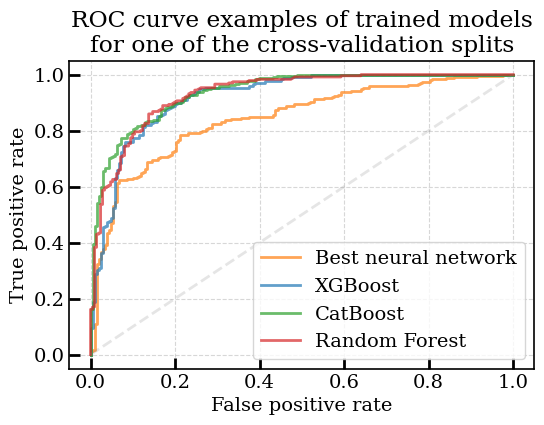

In [16]:
paths = ['best_nn_roc.csv', 'xgboost.csv', 'catboost.csv', 'rf.csv']
names = ['Best neural network', 'XGBoost', 'CatBoost', 'Random Forest']
col = [u'#ff7f0e', u'#1f77b4', u'#2ca02c', u'#d62728']# #['blue', 'red', 'green', 'purple']
lss = [ ':', '-.', '-', '--']

fig, ax = plt.subplots(figsize=(6, 4))
for i, name in enumerate(names):
    roc = pd.read_csv(f'roc_curves/{paths[i]}')
    plt.plot(roc['fpr'], roc['tpr'], label=name, color=col[i],  alpha=0.7)
plt.plot([0, 1], [0, 1], ls='--', alpha=0.2, c='gray')

plt.title('ROC curve examples of trained models\nfor one of the cross-validation splits')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
ax.grid('on')
plt.legend()
#plt.savefig('roc_curves/roc.pdf', dpi=400, format='pdf', bbox_inches="tight")